# Tutorial on collocating a dataset  with lagged data

#1) You will need to point the code to your input file.

#2) Ensure that your input file has the following Variables and Names:
    #Latitude = 'lat'
    #Longitude = 'lon'
    #Time = 'time'
    #Year = 'year'
    #Month = 'month'
    #Day = 'day'
    #Date = 'date'


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
import timeit
# filter some warning messages
warnings.filterwarnings("ignore") 
#from geopy.distance import geodesic 

####################you will need to change some paths here!#####################
#list of input files
#filename_bird='f:/data/project_data/NASA_biophysical/collocated_data/zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final.csv'

adir = 'F:/data/project_data/NASA_biophysical/jeff_collocations/'

filename_bird=adir + 'allStationMetadata.csv'

#output files
filename_bird_out= adir + 'zoo_selgroups_HadSST_relabundance_5aug2019_plumchrusV_4regions_final_satsst'
#################################################################################


## Reading CSV datasets

In [2]:
#read in csv file in to panda dataframe & into xarray
df_bird = pd.read_csv(filename_bird)

df_bird

,Unnamed: 0,year,station,date,time,lat,lon,bottom_depth,tdr_depth,month,day
0,1,2011,110,5/13/11,12:00,36.5833,-122.1750,2304,34.0,5,13
1,3,2012,110,5/8/12,12:00,36.5833,-122.1750,2304,34.0,5,8
2,4,2011,112,5/13/11,12:00,36.6550,-121.9467,73,37.0,5,13
3,5,2012,112,5/8/12,12:00,36.6550,-121.9467,73,27.0,5,8
4,6,2011,114,5/12/11,12:00,36.7667,-121.8667,73,36.0,5,12
...,...,...,...,...,...,...,...,...,...,...,...
134,142,2017,493,5/11/17,12:00,35.0000,-120.8833,192,33.0,5,11
135,143,2015,495,6/10/15,12:00,35.0000,-121.1167,532,32.0,6,10
136,144,2016,495,5/13/16,12:00,35.0000,-121.1167,532,27.0,5,13
137,145,2017,495,5/12/17,12:00,35.0000,-121.1167,532,30.0,5,12


In [3]:
# calculate time, it needs a datetime64[ns] format
df_bird.insert(0,'Year',df_bird['year'])
df_bird.insert(1,'Month',df_bird['month'])
df_bird.insert(2,'Day',df_bird['day'])
df_bird=df_bird.drop(columns={'day','month','year'})
df_bird['time'] = df_bird['time'].apply(lambda x: x.zfill(8))
df_bird.insert(3,'Hour',df_bird['time'].apply(lambda x: x[:2]))
df_bird.insert(4,'Min',df_bird['time'].apply(lambda x: x[3:5]))
df_bird.insert(0,'time64',pd.to_datetime(df_bird[list(df_bird)[0:4]]))
df_bird=df_bird.drop(columns={'Day','Month','Year','Hour','Min','time','date'})

# transform to x array
ds_bird = df_bird.to_xarray()

In [4]:
df_bird

,time64,Unnamed: 0,station,lat,lon,bottom_depth,tdr_depth
0,2011-05-13,1,110,36.5833,-122.1750,2304,34.0
1,2012-05-08,3,110,36.5833,-122.1750,2304,34.0
2,2011-05-13,4,112,36.6550,-121.9467,73,37.0
3,2012-05-08,5,112,36.6550,-121.9467,73,27.0
4,2011-05-12,6,114,36.7667,-121.8667,73,36.0
...,...,...,...,...,...,...,...
134,2017-05-11,142,493,35.0000,-120.8833,192,33.0
135,2015-06-10,143,495,35.0000,-121.1167,532,32.0
136,2016-05-13,144,495,35.0000,-121.1167,532,27.0
137,2017-05-12,145,495,35.0000,-121.1167,532,30.0


<xarray.DataArray 'lat' ()>
array(32.7167) <xarray.DataArray 'lat' ()>
array(38.4667) <xarray.DataArray 'lon' ()>
array(-123.71) <xarray.DataArray 'lon' ()>
array(-117.5833)


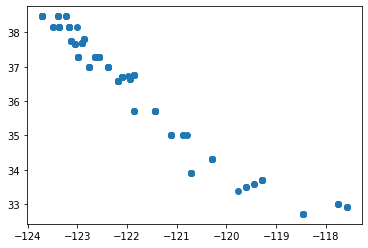

In [5]:
#just check lat/lon & see looks okay
minlat,maxlat=ds_bird.lat.min(),ds_bird.lat.max()
minlon,maxlon=ds_bird.lon.min(),ds_bird.lon.max()
plt.scatter(ds_bird.lon,ds_bird.lat)
print(minlat,maxlat,minlon,maxlon)

In [43]:
def get_data():
    
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
#    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
#    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
#    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
#    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sat_data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
#    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
#    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #get bathymetry from ETOPO1
    fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
    ds = xr.open_dataset(fname_topo)
    ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
    tem = ds_topo.z.attrs
    tem['var_name']='etopo_depth'
    ds_topo.z.attrs=tem
    
    ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-DAILY')
    for var in ds_color:
        if not var=='chlor_a':
            ds_color = ds_color.drop(var)

    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
               'color':ds_color,
              'topo':ds_topo}
#    clim_dict={'aviso_clim':ds_aviso_clim,
#               'wnd_clim':ds_ccmp_clim,
#               'sst_clim':ds_sst_clim}
  
    return data_dict#,clim_dict

#data,clim = get_data()

In [36]:
#Resolution of the Satellite Data is 0.2 degrees.
#If you want to smooth the data, change smooth_lat and smooth lon to the number of 
#grid cells you want to include.  
#example: smooth_lat = 3 will compute a rolling average over 3 grid cells which equals 0.6 deg 
#smooth_lat=1
#smooth_lon=1
#ds = ds.rolling(lat=smooth_lat,center=True,keep_attrs=True).mean(keep_attrs=True)
#ds = ds.rolling(lon=smooth_lon,center=True,keep_attrs=True).mean(keep_attrs=True)
#ds

In [44]:
#ds

# Collocate all data with bird data

In [45]:
ilen_bird = len(ds_bird.lat)


In [46]:
def set_attr(ds1,ds2):
    for var in ds1:
        ds2[var].attrs=ds1[var].attrs
    return ds2



In [47]:
data = get_data()
for name in data:
    ds_data=data[name]
    ds_mon = ds_data.rolling(time=30, center=False).mean(dim='time',keep_attrs=True)
    ds_mon = set_attr(ds_data,ds_mon)
    ds_15 = ds_data.rolling(time=15, center=False).mean(keep_attrs=True)
    ds_15 = set_attr(ds_data,ds_15)
    ds_week = ds_data.rolling(time=7, center=False).mean(keep_attrs=True)
    ds_week = set_attr(ds_data,ds_week)
    ds_2dy = ds_data.rolling(time=2, center=False).mean(keep_attrs=True)
    ds_2dy = set_attr(ds_data,ds_2dy)
    for var in ds_data:
        ds_data[var+'_1mon']=ds_mon[var]
        ds_data[var+'_15dy']=ds_15[var]
        ds_data[var+'_1week']=ds_week[var]
        ds_data[var+'_2dy']=ds_2dy[var]
    
    if name=='topo':
        continue
    for var in ds_data:
        var_tem=var
        ds_bird[var_tem]=xr.DataArray(np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(len(ds_bird.lat)):
    #    for i in range(len(ds_bird.lat)):
    #    if ds_bird.time[i]<ds_data.time.min():
    #        continue
    #    if ds_bird.time[i]>ds_data.time.max():
    #        continue
        t1,t2 = ds_bird.time64[i]-np.timedelta64(24,'h'), ds_bird.time64[i]+np.timedelta64(24,'h')
        lat1,lat2=ds_bird.lat[i]-.25,ds_bird.lat[i]+.25
        lon1,lon2=ds_bird.lon[i]-.25,ds_bird.lon[i]+.25
        #tem = ds_data.sel(time=ds_bird.time64[i])
        tem = ds_data.sel(time=ds_bird.time64[i]).sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
        tem = tem.interp(time=ds_bird.time64[i],lat=ds_bird.lat[i],lon=ds_bird.lon[i])
        #tem = tem.load()
        for var in ds_data:
            var_tem=var
            ds_bird[var_tem][i]=tem[var].data
        if int(i/100)*100==i:
            print(i,len(ds_bird.lat))

    #output data
   #df_bird = ds_bird.to_dataframe()
    #df_bird.to_csv(filename_bird_out)
    ds_bird.to_netcdf(filename_bird_out+name+'.nc')

var vgosa_2dy


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\IPython\core\interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-d147483324eb>", line 35, in <module>
    tem = ds_data.sel(time=ds_bird.time64[i]).sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
  File "C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\xarray\core\dataset.py", line 651, in load
    evaluated_data = da.compute(*lazy_data.values(), **kwargs)
  File "C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\base.py", line 437, in compute
    results = schedule(dsk, keys, **kwargs)
  File "C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\threaded.py", line 84, in get
    **kwargs
  File "C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\local.py", line 475, in get_async
    key, res_info, failed = queue_get(queue)
  File "C:\Users\gentemann\Minic

TypeError: object of type 'NoneType' has no len()

In [ ]:
var2


In [ ]:
#test rolling to check
print(da.data)
da = xr.DataArray(np.linspace(0, 11, num=12),coords=[pd.date_range( "15/12/1999", periods=12, freq=pd.DateOffset(months=1), )],dims="time",)
dar = da.rolling(time=3,center=False).mean()  #before and up too
print(dar.data)